In [1]:
!pip install geopandas
!pip install plotly --upgrade
!pip install mapclassify --upgrade

import pyproj
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
import seaborn as sns
import glob
import plotly
from datetime import datetime
import re
import geopandas
from matplotlib.colors import Normalize
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.pyplot import figure
from mapclassify import UserDefined
from google.colab import drive
%matplotlib inline

drive.mount("/content/drive")

     |████████████████████████████████| 1.0MB 6.8MB/s 
     |████████████████████████████████| 6.6MB 18.0MB/s 
     |████████████████████████████████| 15.4MB 192kB/s 
     |████████████████████████████████| 20.6MB 1.5MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
Mounted at /content/drive


In [2]:
listings = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/listings_zipcodes.csv").drop(columns = ["Unnamed: 0", "X", "AFFGEOID10",	"GEOID10",	"ALAND10",	"AWATER10", 'optional']).rename(
      columns = {"ZCTA5CE10": "zipcodes"}
  )
demographics = pd.read_csv("/content/drive/MyDrive/Datasets/demographics.csv")
real_estate = pd.read_csv("/content/drive/MyDrive/Work/Citadel 2021/Data/real_estate.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
real_estate

,type,zipcode,city,state,metro,county,size_rank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,ZHVI,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,886900,893400,888500,883000,887900,895100,901400,911100,915300,911400,908300,908600,904200,899400,901600,911500,926600,948100,970000,979800,983700,993700,1007800,1031000.0,1055800.0,1063500.0,1062900.0,1080800,1109400,1132500,1137500,1137700,1152700,1156000.0,1140200,1130000,1131900,1149600,1198400,1247000
1,ZHVI,60657,Chicago,IL,Chicago,Cook,2,146700.0,146500.0,146300.0,146300.0,146800.0,147100.0,147300.0,147800.0,148600.0,149100.0,149600.0,151100.0,153200.0,155100.0,157200.0,159100.0,160000.0,160800.0,162200.0,163200.0,164100.0,165600.0,167400.0,168000.0,168100.0,168500.0,168900.0,169100.0,170200.0,172100.0,174500.0,177100.0,180500.0,...,298800,298700,296700,296500,299700,303200,304700,305200,306800,309000,308800,306700,306600,308800,310200,310000,310400,310000,310300,311800,312500,311600,311800,313100.0,315000.0,317000.0,317500.0,317500,317900,318600,318200,318100,318800,320200.0,320800,322000,323800,326100,327800,329100
2,ZHVI,60614,Chicago,IL,Chicago,Cook,3,198000.0,195500.0,194200.0,193800.0,193900.0,194500.0,195900.0,197900.0,200100.0,199700.0,197700.0,197600.0,199700.0,200500.0,201000.0,202100.0,202700.0,202300.0,202500.0,203000.0,203200.0,203800.0,205200.0,206900.0,209100.0,210900.0,213700.0,217400.0,220600.0,222200.0,223300.0,224300.0,225900.0,...,361900,363900,365100,367200,370100,370900,368800,365200,364000,366900,368700,363600,357600,358000,359900,359300,359100,362000,368700,379500,386800,390300,393200,397200.0,400500.0,404000.0,403500.0,401400,400100,400700,401900,406000,414100,417800.0,417400,418400,414100,404100,406400,415500
3,ZHVI,79936,El Paso,TX,El Paso,El Paso,4,70800.0,71000.0,71000.0,71400.0,71200.0,71600.0,72600.0,73100.0,72800.0,72800.0,72900.0,73100.0,73100.0,73300.0,73500.0,73900.0,74500.0,74900.0,75200.0,75400.0,75800.0,76200.0,76500.0,76700.0,76500.0,76400.0,76500.0,76300.0,76100.0,75900.0,75800.0,75800.0,75800.0,...,110600,110600,110800,111200,111500,111400,111300,111400,111500,111600,111700,111700,111600,111500,111500,111500,111700,111800,111800,111800,111500,111200,111200,111200.0,111200.0,111500.0,112000.0,112500,113200,113700,113800,113900,114100,114500.0,114900,115000,114700,114700,114800,114700
4,ZHVI,60640,Chicago,IL,Chicago,Cook,5,102300.0,101300.0,100700.0,100600.0,100700.0,101300.0,102300.0,103200.0,104400.0,105200.0,105600.0,106400.0,106800.0,106600.0,106900.0,107900.0,109100.0,109600.0,109000.0,108200.0,107900.0,107900.0,108000.0,108900.0,110900.0,112800.0,114100.0,115400.0,116400.0,117000.0,117800.0,119400.0,120800.0,...,183900,185200,186100,186100,186500,188900,191000,192400,193200,193400,192200,191600,192700,195700,197200,195700,193500,192600,193400,195200,195900,195900,196000,196000.0,195600.0,195800.0,195700.0,197500,199600,199900,198800,199200,200100,201500.0,203000,205100,206700,206500,206200,206700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29106,ZRI,12720,Bethel,NY,NaN,Sullivan,15907,NaN,NaN,NaN,

In [4]:
#Fix misspelling of December as Decemeber
listings['date'] = listings['date'].str.replace("Decemeber", "December")

In [5]:
def remove_dollar(x):
  x = str(x)
  x = x.replace(",", "")
  x = x.replace("$", "")
  return float(x)

listings["price"] = listings["price"].apply(lambda x: remove_dollar(x))
listings = listings[~listings.zipcodes.isna()]
listings.zipcodes = listings.zipcodes.astype(int)
listings

,date,price,neighborhood,reviews,zipcodes,longitude,latitude
0,August 2016,75.0,15,38.0,37214,-86.676298,36.164599
1,August 2016,275.0,5,32.0,37216,-86.742712,36.200263
2,August 2016,147.0,21,0.0,37209,-86.824133,36.154810
3,August 2016,110.0,7,0.0,37206,-86.712101,36.195480
4,August 2016,57.0,5,11.0,37207,-86.758810,36.207139
...,...,...,...,...,...,...,...
523467,April 2021,157.0,central business district,0.0,70130,-90.069310,29.952760
523468,April 2021,205.0,central business district,0.0,70130,-90.069490,29.952440
523469,April 2021,197.0,central business district,0.0,70112,-90.069710,29.954160
523470,April 2021,219.0,central business district,0.0,70130,-90.069390,29.952190


#Create dataset of zipcode listings by date





In [6]:
zip_date = listings.groupby(["zipcodes", "date"])[["price", "reviews"]].agg(["median","count"]).droplevel(level = 0, axis = 1)
zip_date["median_price"] = zip_date.iloc[:,0]
zip_date["median_reviews"] = zip_date.iloc[:,2]
zip_date = zip_date.iloc[:,3:6]
#Create dataset of zipcode listings by date

zip_date

count  median_price  median_reviews
zipcodes date                                               
37013    April 2017         59          60.0             5.0
         April 2018         82          80.0             7.5
         April 2019         76          95.0            11.0
         August 2016        59          75.0             3.0
         August 2018        82          85.0             7.0
...                        ...           ...             ...
70139    September 2016     14         500.0             0.0
         September 2017     14         299.0             1.5
         September 2018     31         316.0             8.0
         September 2019     30         999.0            12.0
         September 2020     24         117.5            32.5

[2117 rows x 3 columns]

In [7]:
#Zipcode and date are columns; all zipcodes with >7000 are New Orleans, otherwise, Nashville.
zip_date = zip_date.reset_index().rename(columns = {"zipcodes": "zipcode"})

#Convert to actual dates to allow sorting
zip_date["date"] = pd.to_datetime(zip_date["date"])
zip_date = zip_date.sort_values(by = ["zipcode", "date"])

#Convert back after sorting
#zip_date.date = zip_date.date.apply(lambda x: x.strftime("%B %Y"))

zip_date = zip_date.reset_index().drop(columns = "index")

zip_date

,zipcode,date,count,median_price,median_reviews
0,37013,2015-06-01,13,85.0,3.0
1,37013,2015-10-01,19,75.0,3.0
2,37013,2016-05-01,43,75.0,2.0
3,37013,2016-08-01,59,75.0,3.0
4,37013,2016-09-01,65,70.0,3.0
...,...,...,...,...,...
2112,70139,2020-12-01,26,94.0,4.0
2113,70139,2021-01-01,26,95.0,6.0
2114,70139,2021-02-01,26,130.0,7.0
2115,70139,2021-03-01,32,147.5,7.0


In [8]:
#Only evaluate New Orleans zipcodes with >20 data points before 2020
new_orleans_values = dict(zip_date[(zip_date["zipcode"] > 40000) & (zip_date["date"] < pd.to_datetime("January 1 2020"))].zipcode.value_counts())

#Only evaluate Nashville zipcodes with >15 data points before 2020
nashville_values = dict(zip_date[(zip_date["zipcode"] < 40000) & (zip_date["date"] < pd.to_datetime("January 1 2020"))].zipcode.value_counts())

valid_zips = []

for j in new_orleans_values.keys():
  if new_orleans_values[j] > 20:
    valid_zips.append(j)

for j in nashville_values.keys():
  if nashville_values[j] > 20:
    valid_zips.append(j)

zip_date = zip_date[zip_date["zipcode"].isin(valid_zips)].reset_index().drop(columns = ["index"])
zip_date = zip_date[zip_date["date"] != pd.to_datetime("2020-07-01")] #remove July 2020 New Orleans data because lack of prices
zip_date

,zipcode,date,count,median_price,median_reviews
0,37013,2015-06-01,13,85.0,3.0
1,37013,2015-10-01,19,75.0,3.0
2,37013,2016-05-01,43,75.0,2.0
3,37013,2016-08-01,59,75.0,3.0
4,37013,2016-09-01,65,70.0,3.0
...,...,...,...,...,...
2051,70139,2020-12-01,26,94.0,4.0
2052,70139,2021-01-01,26,95.0,6.0
2053,70139,2021-02-01,26,130.0,7.0
2054,70139,2021-03-01,32,147.5,7.0


#Create synthetic values in zipcode dataset

In [9]:
#Create a dataset that fills in empty dates with nan values
impute_dates = pd.to_datetime(pd.date_range(start = "2015-8-01", end = "2021-04-1", freq = "MS"))
impute_dates

rows = {}
curr = len(zip_date)

for zip in valid_zips:
  for date in impute_dates:
    if (date not in list(zip_date[zip_date["zipcode"] == zip]["date"])): #inefficient, should change if we get a large amount of data (unlikely)
      rows[curr] = [zip, date, np.nan, np.nan, np.nan]
    curr += 1

zip_date_with_nan = zip_date.from_dict(rows, orient = "index", columns = ["zipcode", "date", "count", "median_price", "median_reviews"])
zip_date_with_nan = zip_date.append(zip_date_with_nan)
zip_date_with_nan.sort_values(by = ["zipcode", "date"]).reset_index().drop(columns = ['index'])

,zipcode,date,count,median_price,median_reviews
0,37013,2015-06-01,13.0,85.0,3.0
1,37013,2015-08-01,NaN,NaN,NaN
2,37013,2015-09-01,NaN,NaN,NaN
3,37013,2015-10-01,19.0,75.0,3.0
4,37013,2015-11-01,NaN,NaN,NaN
...,...,...,...,...,...
3647,70139,2020-12-01,26.0,94.0,4.0
3648,70139,2021-01-01,26.0,95.0,6.0
3649,70139,2021-02-01,26.0,130.0,7.0
3650,70139,2021-03-01,32.0,147.5,7.0


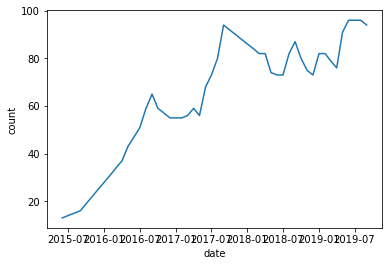

In [10]:
#regress between known values to impute unknown values
def diff_month(d1, d2): #https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
    return (d1.year - d2.year) * 12 + d1.month - d2.month

rows = {}
curr = len(zip_date)
pastrow = -1

for row in zip_date.iterrows():
  if pastrow != -1:
    impute_dates = pd.to_datetime(pd.date_range(start = pastrow[1].date, end = row[1].date, freq = "MS"))

    if len(impute_dates) > 2 and pastrow[1].zipcode == row[1].zipcode:
      
      count_impute = [pastrow[1]["count"]] * (len(impute_dates))
      if pastrow[1]["count"] != row[1]["count"]:
        count_impute = np.arange(pastrow[1]["count"], row[1]["count"], (row[1]["count"] - pastrow[1]["count"]) / len(impute_dates), dtype = int) 

      price_impute = [pastrow[1]["median_price"]] * (len(impute_dates))
      if pastrow[1]["median_price"] != row[1]["median_price"]:
        price_impute = np.arange(pastrow[1]["median_price"], row[1]["median_price"], (row[1]["median_price"] - 
                                                                                      pastrow[1]["median_price"]) / len(impute_dates), dtype = int) 
      review_impute = [pastrow[1]["median_reviews"]] * (len(impute_dates))
      if pastrow[1]["median_reviews"] != row[1]["median_reviews"]:
        review_impute = np.arange(pastrow[1]["median_reviews"], row[1]["median_reviews"], (row[1]["median_reviews"] - 
                                                                              pastrow[1]["median_reviews"]) / len(impute_dates), dtype = int)
      
      for j in range(1, len(impute_dates) - 1):
        rows[curr] = [row[1].zipcode, impute_dates[j], count_impute[j], price_impute[j], review_impute[j]]
        curr += 1

  pastrow = row

zip_date_regress = zip_date.from_dict(rows, orient = "index", columns = ["zipcode", "date", "count", "median_price", "median_reviews"])
zip_date_regress = zip_date.append(zip_date_regress).sort_values(by = ["zipcode", "date"]).reset_index().drop(columns = ['index'])
sns.lineplot(x = zip_date_regress[zip_date_regress["zipcode"] == 37013.0]["date"], y = zip_date_regress[zip_date_regress["zipcode"] == 37013.0]["count"])

In [11]:
fig = go.Figure()
for zip in zip_date[zip_date["zipcode"] > 70000]["zipcode"].unique():
  fig.add_trace(go.Scatter(x = zip_date[zip_date["zipcode"] == zip]["date"], y = zip_date[zip_date["zipcode"] == zip]["count"], name = str(zip), mode = "lines+markers"))

fig.update_layout(title = "New Orleans Airbnb Bookings by Zipcode")
fig.update_xaxes(title = "Date")

In [12]:
zip_date_regress.to_csv("zip_analysis.csv")

In [13]:
fig = go.Figure()
for zip in zip_date[zip_date["zipcode"] < 70000]["zipcode"].unique():
  fig.add_trace(go.Scatter(x = zip_date[zip_date["zipcode"] == zip]["date"], y = zip_date[zip_date["zipcode"] == zip]["count"], name = str(zip), mode = "lines+markers"))

fig.update_layout(title = "Nashville Airbnb Bookings by Zipcode")
fig.update_xaxes(title = "Date")

#Dataset of neighborhoods by Date

In [14]:
#Since zipcodes was ambiguous, we can try neighborhoods. First do neighborhoods, then classify each neighborhood to a zipcode depending on the majority of airbnb zipcodes
listings['neighborhood'] = listings['neighborhood'].str.lower()
dict(listings[listings["zipcodes"] >= 70000].neighborhood.value_counts())

#Load Inside Airbnb Geojsons file
new_orleans_neighborhoods = geopandas.read_file("/content/drive/MyDrive/Work/Citadel 2021/Data/Geojsons/neighbourhoods.geojson")
geo_neighborhoods = list(new_orleans_neighborhoods.neighbourhood.str.lower().unique())

def rename_neighborhood(x):
  if "old aurora" in x:
    return "old aurora"
  if "algiers" in x:
    return "algiers point"
  if "aurora - walnut bend - huntlee" in x:
    return "old aurora"
  if "audubon" in x:
    return "audubon"
  if "b. w. cooper" in x:
    return "b. w. cooper"
  if "central city" in x:
    return "central city"
  if "edgelake" in x:
    return "little woods"
  if "fairgrounds" in x:
    return "fairgrounds"
  if "gert town" in x:
    return "gert town"
  if "iberville" in x:
    return "iberville"
  if "lake terrace" in x:
    return "lake terrace & oaks"
  if "florida" in x:
    return "florida area"
  if "lakewood" in x:
    return "lakewood"
  if "leonidas" in x:
    return "leonidas"
  if "st. thomas" in x:
    return "st. thomas dev"
  if "st. bernard area" in x:
    return "st. bernard area"
  if "treme" in x:
    return 'treme - lafitte'
  if "vieux" in x:
    return "french quarter"

  return x

listings['neighborhood'] = listings['neighborhood'].apply(lambda x: rename_neighborhood(x))

#check if there are any neighborhoods not included after cleaning
for i in listings[listings["zipcodes"] >= 70000].neighborhood.unique():
  if i not in geo_neighborhoods:
    print(i)

for i in geo_neighborhoods:
  if i not in listings[listings["zipcodes"] >= 70000].neighborhood.unique():
    print(i)

florida dev


In [15]:
#Create dataset of neighborhood listings by date

neighborhood_date = listings[listings.zipcodes > 70000].groupby(["neighborhood", "date"])[["price", "reviews"]].agg(["median","count"]).droplevel(level = 0, axis = 1)
neighborhood_date["median_price"] = neighborhood_date.iloc[:,0]
neighborhood_date["median_reviews"] = neighborhood_date.iloc[:,2]
neighborhood_date = neighborhood_date.iloc[:,3:6]

neighborhood_zips = pd.DataFrame(listings[listings.zipcodes > 70000][['neighborhood', 'zipcodes']].value_counts(), columns = ["count"])
neighborhood_zips = neighborhood_zips.reset_index().sort_values(by = "count", ascending = False).drop_duplicates(subset = "neighborhood", keep = "first").reset_index().drop(columns = ["index", "count"])
neighborhood_zips

neighborhood_date = neighborhood_date.reset_index()

#Convert to actual dates to allow sorting
neighborhood_date["date"] = pd.to_datetime(neighborhood_date["date"])
neighborhood_date = neighborhood_date.sort_values(by = ["neighborhood", "date"])

neighborhood_date = neighborhood_date.reset_index().drop(columns = "index")
neighborhood_date = neighborhood_date.merge(neighborhood_zips, on = "neighborhood", how = "left")
neighborhood_date = neighborhood_date[neighborhood_date["date"] != pd.to_datetime("2020-07-01")] #remove July 2020 New Orleans data because lack of prices
neighborhood_date

,neighborhood,date,count,median_price,median_reviews,zipcodes
0,algiers point,2015-01-01,28,156.5,6.5,70114
1,algiers point,2015-06-01,23,125.0,6.0,70114
2,algiers point,2015-08-01,20,100.0,6.0,70114
3,algiers point,2015-09-01,25,115.0,7.0,70114
4,algiers point,2015-10-01,32,125.0,3.5,70114
...,...,...,...,...,...,...
4044,whitney,2020-12-01,28,109.0,20.5,70114
4045,whitney,2021-01-01,28,109.0,20.5,70114
4046,whitney,2021-02-01,32,137.5,14.0,70114
4047,whitney,2021-03-01,32,150.0,16.0,70114


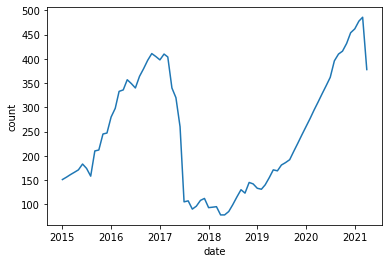

In [16]:
#regress between known values to impute unknown values
def diff_month(d1, d2): #https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
    return (d1.year - d2.year) * 12 + d1.month - d2.month

rows = {}
curr = len(neighborhood_date)
pastrow = -1

for row in neighborhood_date.iterrows():
  if pastrow != -1:
    impute_dates = pd.to_datetime(pd.date_range(start = pastrow[1].date, end = row[1].date, freq = "MS"))

    if len(impute_dates) > 2 and pastrow[1].neighborhood == row[1].neighborhood:
      
      count_impute = [pastrow[1]["count"]] * (len(impute_dates))
      if pastrow[1]["count"] != row[1]["count"]:
        count_impute = np.arange(pastrow[1]["count"], row[1]["count"], (row[1]["count"] - pastrow[1]["count"]) / len(impute_dates), dtype = int) 

      price_impute = [pastrow[1]["median_price"]] * (len(impute_dates))
      if pastrow[1]["median_price"] != row[1]["median_price"]:
        price_impute = np.arange(pastrow[1]["median_price"], row[1]["median_price"], (row[1]["median_price"] - 
                                                                                      pastrow[1]["median_price"]) / len(impute_dates), dtype = int) 
      review_impute = [pastrow[1]["median_reviews"]] * (len(impute_dates))
      if pastrow[1]["median_reviews"] != row[1]["median_reviews"]:
        review_impute = np.arange(pastrow[1]["median_reviews"], row[1]["median_reviews"], (row[1]["median_reviews"] - 
                                                                              pastrow[1]["median_reviews"]) / len(impute_dates), dtype = int)
      
      for j in range(1, len(impute_dates) - 1):
        rows[curr] = [row[1].neighborhood, impute_dates[j], count_impute[j], price_impute[j], review_impute[j], row[1].zipcodes]
        curr += 1

  pastrow = row

neighborhood_date_regress = neighborhood_date.from_dict(rows, orient = "index", columns = ["neighborhood", "date", "count", "median_price", "median_reviews", "zipcodes"])
neighborhood_date_regress = neighborhood_date.append(neighborhood_date_regress).sort_values(by = ["neighborhood", "date"]).reset_index().drop(columns = ['index'])
sns.lineplot(x = neighborhood_date_regress[neighborhood_date_regress["neighborhood"] == "french quarter"]["date"], y = neighborhood_date_regress[neighborhood_date_regress["neighborhood"] == "french quarter"]["count"])

In [17]:
#Remove insignificant neighborhoods
print(neighborhood_date.neighborhood.value_counts())
neighborhood_date = neighborhood_date[neighborhood_date.neighborhood != "fischer dev"] #Fischer dev only has 3 appearances
pd.options.display.max_rows = 20
pd.DataFrame(neighborhood_date.groupby("neighborhood")["count"].mean()).sort_values(by = "count")

florida area                 60
st. claude                   60
dillard                      60
broadmoor                    60
st. bernard area             60
                             ..
read blvd west               41
new aurora - english turn    35
viavant - venetian isles     35
b. w. cooper                 33
fischer dev                   2
Name: neighborhood, Length: 71, dtype: int64


,count
neighborhood,
viavant - venetian isles,1.657143
b. w. cooper,2.000000
lakeshore - lake vista,2.344828
new aurora - english turn,2.771429
u.s. naval base,2.792453
...,...
marigny,360.416667
treme - lafitte,364.166667
seventh ward,396.600000


In [18]:
fig = go.Figure()
for neighborhood in neighborhood_date["neighborhood"].unique():
  fig.add_trace(go.Scatter(x = neighborhood_date[neighborhood_date["neighborhood"] == neighborhood]["date"], y = neighborhood_date[neighborhood_date["neighborhood"] == neighborhood]["count"], 
                           name = neighborhood, mode = "lines+markers", visible = "legendonly"))

fig.update_layout(title = "New Orleans Airbnb Bookings by Neighborhood")
fig.add_shape(type="rect", x0 = pd.to_datetime("March 2017"), x1 = pd.to_datetime("July 2017"), y0 = 0, y1 = 2500, 
              line = dict(color = "LightSkyBlue"), fillcolor = "LightSkyBlue", opacity = 0.3)
fig.add_shape(type="rect", x0 = pd.to_datetime("March 2020"), x1 = pd.to_datetime("April 2021"), y0 = 0, y1 = 2500, 
              line = dict(color = "LightSkyBlue"), fillcolor = "LightSkyBlue", opacity = 0.3)
fig.update_xaxes(title = "Date")

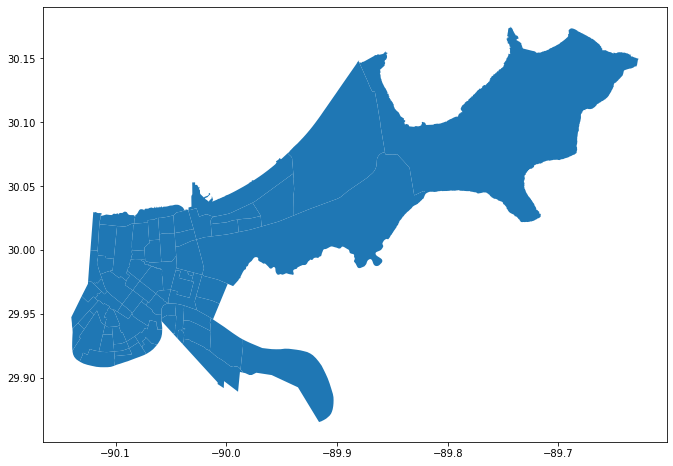

In [19]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots(1,1)
new_orleans_neighborhoods.plot(ax = ax)

In [20]:
new_orleans_neighborhoods.rename(columns = {"neighbourhood" : "neighborhood"}, inplace = True)
new_orleans_neighborhoods['neighborhood'] = new_orleans_neighborhoods['neighborhood'].str.lower()
neighborhood_synthetic = new_orleans_neighborhoods.copy()
dates = pd.to_datetime(pd.date_range(start = "2015-8-01", end = "2021-04-1", freq = "MS"))
for date in dates:
  neighborhood_synthetic = neighborhood_synthetic.merge(right = neighborhood_date_regress[neighborhood_date_regress["date"] == date][["neighborhood","count"]]
                             .rename(columns = {"count": date.strftime("%B %Y")}), on = "neighborhood", how = "left")

neighborhood_synthetic

,neighborhood,neighbourhood_group,geometry,August 2015,September 2015,October 2015,November 2015,December 2015,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,November 2016,December 2016,January 2017,February 2017,March 2017,April 2017,May 2017,June 2017,July 2017,August 2017,September 2017,October 2017,November 2017,December 2017,January 2018,February 2018,March 2018,April 2018,May 2018,June 2018,July 2018,August 2018,September 2018,October 2018,November 2018,December 2018,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019,September 2019,October 2019,November 2019,December 2019,January 2020,February 2020,March 2020,April 2020,May 2020,June 2020,July 2020,August 2020,September 2020,October 2020,November 2020,December 2020,January 2021,February 2021,March 2021,April 2021
0,garden district,None,"MULTIPOLYGON (((-90.07921 29.92804, -90.08001 ...",9.0,15.0,18.0,20.0,21.0,23.0,26.0,30.0,33.0,36.0,28.0,34.0,39.0,47.0,42.0,44.0,46.0,44.0,59.0,64.0,66.0,65.0,63.0,47.0,50.0,47.0,50.0,52.0,52.0,48.0,48.0,49.0,51.0,49.0,50.0,53.0,52.0,54.0,53.0,54.0,51.0,52.0,53.0,53.0,42.0,52.0,52.0,51.0,44.0,45.0,47.0,49.0,51.0,53.0,55.0,57.0,59.0,61.0,63.0,65.0,70.0,70.0,70.0,88.0,62.0,64.0,62.0,66.0,62.0
1,little woods,None,"MULTIPOLYGON (((-89.93949 30.06005, -89.94008 ...",1.0,1.0,1.0,1.0,1.0,3.0,8.0,13.0,12.0,21.0,24.0,23.0,25.0,25.0,27.0,30.0,33.0,28.0,31.0,34.0,28.0,32.0,27.0,19.0,21.0,20.0,20.0,19.0,19.0,19.0,23.0,22.0,23.0,25.0,27.0,32.0,33.0,24.0,32.0,30.0,29.0,34.0,38.0,52.0,54.0,54.0,54.0,67.0,63.0,66.0,69.0,72.0,75.0,78.0,81.0,84.0,87.0,90.0,93.0,96.0,104.0,96.0,96.0,92.0,82.0,84.0,80.0,84.0,86.0
2,iberville,None,"MULTIPOLYGON (((-90.07065 29.95942, -90.07130 ...",NaN,NaN,3.0,4.0,5.0,1.0,2.0,3.0,4.0,5.0,9.0,7.0,10.0,10.0,11.0,7.0,9.0,7.0,4.0,6.0,4.0,4.0,3.0,2.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,3.0,4.0,3.0,5.0,7.0,4.0,7.0,6.0,4.0,8.0,9.0,5.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,12.0,16.0,14.0,4.0,4.0,4.0,4.0,4.0,4.0
3,holy cross,None,"MULTIPOLYGON (((-90.00621 29.95812, -90.01203 ...",6.0,7.0,13.0,13.0,14.0,15.0,13.0,17.0,14.0,14.0,34.0,29.0,28.0,30.0,24.0,27.0,27.0,29.0,29.0,35.0,35.0,35.0,34.0,24.0,26.0,23.0,25.0,29.0,30.0,26.0,46.0,31.0,50.0,40.0,40.0,41.0,38.0,44.0,46.0,45.0,47.0,49.0,49.0,53.0,53.0,55.0,52.0,50.0,52.0,54.0,57.0,60.0,63.0,66.0,69.0,72.0,75.0,78.0,81.0,84.0,98.0,98.0,96.0,100.0,96.0,94.0,102.0,102.0,112.0
4,viavant - venetian isles,None,"MULTIPOLYGON (((-89.82046 30.04341, -89.82070 ...",1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,touro,None,"MULTIPOLYGON (((-90.08773 29.92343, -90.08881 ...",31.0,37.0,30.0,33.0,33.0,38.0,45.0,50.0,54.0,59.0,52.0,52.0,52.0,51.0,51.0,48.0,50.0,52.0,54.0,57.0,57.0,59.0,51.0,32.0,30.0,29.0,34.0,37.0,33.0,38.0,41.0,40.0,43.0,45.0,45.0,46.0,49.0,50.0,46.0,51.0,52.0,51.0,51.0,52.0,56.0,50.0,52.0,52.0,48.0,50.0,53.0,56.0,59.0,62.0,65.0,68.0,71.0,74.0,77.0,80.0,94.0,94.0,94.0,90.0,84.0,84.0,84.0,86.0,84.0
68,french quarter,None,"MULTIPOLYGON (((-90.05233 29.95838, -90.05447 ...",158.0,210.0,212.0,245.0,247.0,280.0,298.0,333.0,336.0,357.0,349.0,340.0,364.0,380.0,397.0,411.0,405.0,398.0,410.0,404.0,340.0,320.0,260.0,105.0,107.0,90.0,96.0,108.0,112.0,93.0,94.0,95.0,78.0,78.0,85.0,99.0,115.0,130.0,123.0,145.0,142.0,133.0,131.0,140.0,155.0,171.0,169.0,181.0,186.0,192.0,209.0,226.0,243.0,260.0,277.0,294.0,311.0,328.0,345.0,362.0,396.0,410.0,416.0,432.0

(-90.16564349999997, -89.6021685, 29.850145, 30.190265)

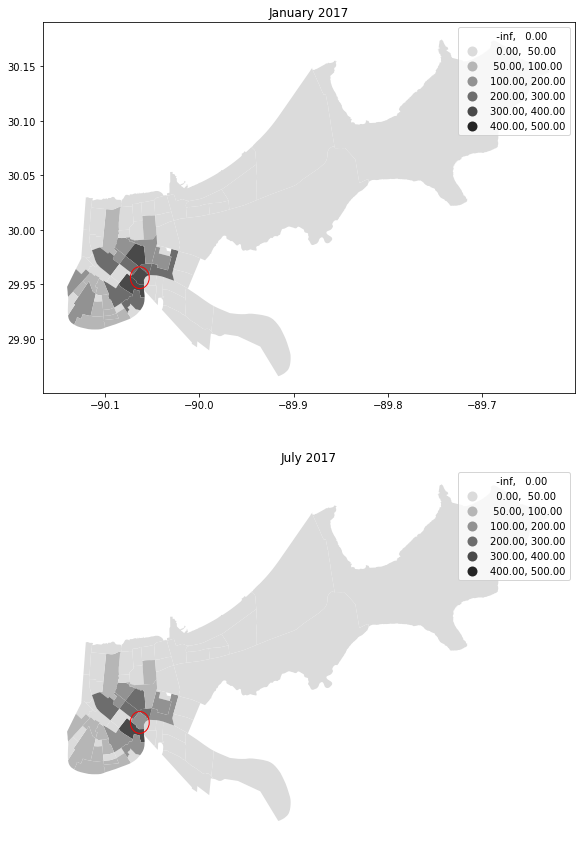

In [21]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axes = plt.subplots(2,1)

left_title = "January 2017"
right_title = "July 2017"

bins = UserDefined(neighborhood_synthetic[right_title], bins=[0,50,100,200,300,400,500]).bins

axes[0].set_title(left_title)
axes[1].set_title(right_title)

circle = plt.Circle((-90.063, 29.956), 0.01, color='r', fill=False, label = "French Quarter")
circle2 = plt.Circle((-90.063, 29.956), 0.01, color='r', fill=False, label = "French Quarter")
axes[0].add_patch(circle)
axes[1].add_patch(circle2)

neighborhood_synthetic.plot(column=left_title, ax=axes[0], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, legend = True, norm=Normalize(0, len(bins)))
neighborhood_synthetic.plot(column=right_title, ax=axes[1], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, legend = True, norm=Normalize(0, len(bins)))
plt.axis('off')

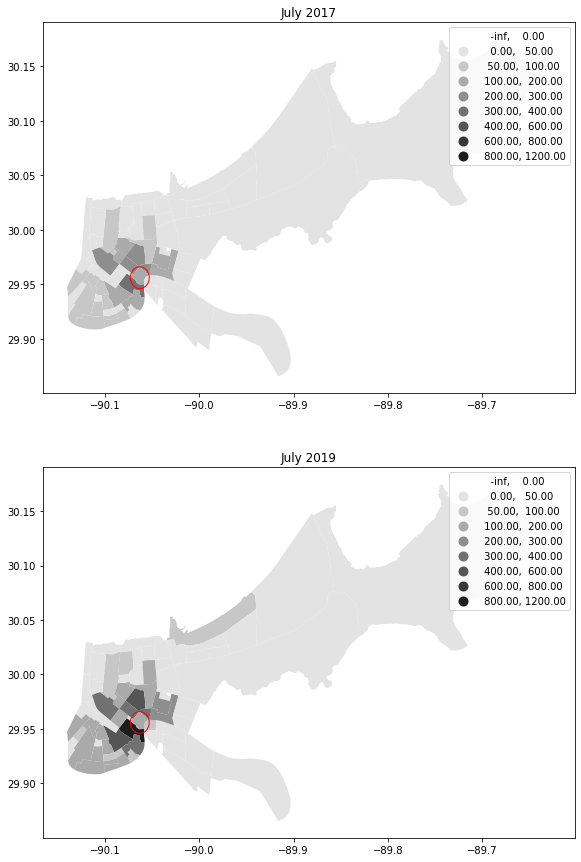

In [22]:
plt.rcParams['figure.figsize'] = [10, 15]
fig, axes = plt.subplots(2,1)

left_title = "July 2017"
right_title = "July 2019"

bins = UserDefined(neighborhood_synthetic[right_title], bins=[0,50,100,200,300,400,600,800,1200]).bins

axes[0].set_title(left_title)
axes[1].set_title(right_title)

circle = plt.Circle((-90.063, 29.956), 0.01, color='r', fill=False, label = "French Quarter")
circle2 = plt.Circle((-90.063, 29.956), 0.01, color='r', fill=False, label = "French Quarter")
axes[0].add_patch(circle)
axes[1].add_patch(circle2)

neighborhood_synthetic.plot(column=left_title, ax=axes[0], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, legend = True, norm=Normalize(0, len(bins)))
neighborhood_synthetic.plot(column=right_title, ax=axes[1], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, legend = True, norm=Normalize(0, len(bins)))


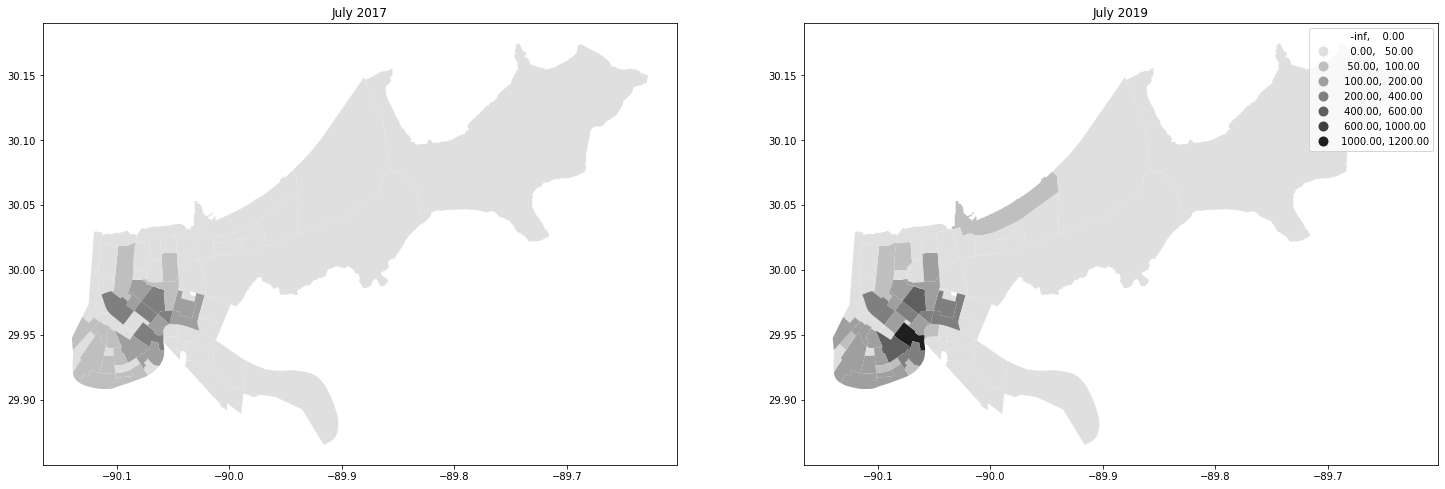

In [23]:
plt.rcParams['figure.figsize'] = [25, 10]
fig, axes = plt.subplots(1,2)

left_title = "July 2017"
right_title = "July 2019"

bins = UserDefined(neighborhood_synthetic[right_title], bins=[0,50,100,200,400,600, 1000, 1200]).bins

axes[0].set_title(left_title)
axes[1].set_title(right_title)

neighborhood_synthetic.plot(column=left_title, ax=axes[0], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, norm=Normalize(0, len(bins)))
neighborhood_synthetic.plot(column=right_title, ax=axes[1], cmap='binary', scheme='userdefined', classification_kwds={'bins':bins}, legend = True, norm=Normalize(0, len(bins)))

In [24]:
neighborhood_synthetic.to_csv("neighborhoods.csv")

In [25]:
fig = go.Figure()
for neighborhood in neighborhood_date["neighborhood"].unique():
  fig.add_trace(go.Scatter(x = neighborhood_date[neighborhood_date["neighborhood"] == neighborhood]["date"], y = neighborhood_date[neighborhood_date["neighborhood"] == neighborhood]["median_price"], 
                           name = neighborhood, mode = "lines+markers", visible = "legendonly"))

fig.update_layout(title = "New Orleans Airbnb Price by Neighborhood")
fig.update_xaxes(title = "Date")

In [26]:
neighborhood_date.groupby(['date'])['median_price'].median()

date
2015-01-01    167.00
2015-06-01    137.50
2015-08-01    131.00
2015-09-01    130.00
2015-10-01    125.00
               ...  
2020-12-01    112.75
2021-01-01    111.00
2021-02-01    127.25
2021-03-01    121.75
2021-04-01    119.50
Name: median_price, Length: 60, dtype: float64